# Credit approval modeling using logistic regression methods

As part of this analysis, a logistic regression model was developed to predict the approval of loan applications based on various financial and personal characteristics of borrowers.

## 1. Characterization of data set variables


    Loan_ID: A unique loan ID.
    Gender: Either male or female.
    Married: Weather Married(yes) or Not Marttied(No).
    Dependents: Number of persons depending on the client.
    Education: Applicant Education(Graduate or Undergraduate).
    Self_Employed: Self-employed (Yes/No).
    ApplicantIncome: Applicant income.
    CoapplicantIncome: Co-applicant income.
    LoanAmount: Loan amount in thousands.
    Loan_Amount_Term: Terms of the loan in months.
    Credit_History: Credit history meets guidelines.
    Property_Area: Applicants are living either Urban, Semi-Urban or Rural.
    Loan_Status: Loan approved (Y/N).


##2. Library loading and primary data analysis

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
prediction = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Github/ЛОгическая регресия/loan_data(1).csv',delimiter=',')

In [6]:
prediction.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [7]:
prediction = prediction.drop(['Loan_ID','Dependents','Property_Area','Self_Employed'], axis=1)

**Exclusion of complicating and uninformative features:**


* Loan_ID — is the unique identifier of each loan and does not contain any useful information for demand analysis or prediction. Using it does not provide any advantage and can only complicate the model.

* Dependents — shows the number of dependents of the borrower. Converting this feature to the one-hot format will increase the number of features and may lead to a strong correlation between the new variables. Therefore, in order to simplify the model and avoid excessive correlation, it was decided to exclude this feature.

* Self_Employed — is a categorical feature indicating the status of self-employment. Its contribution to the quality of the model turns out to be insignificant, and removing this feature helps reduce the complexity of the model without significant loss of information.

* Property_Area is a categorical feature that characterizes the borrower's area. Converting it to one-hot will increase the number of features and may cause a strong correlation between them. In order to simplify the model and avoid multicollinearity, it was decided to exclude this feature at this stage.

In [8]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             376 non-null    object 
 1   Married            381 non-null    object 
 2   Education          381 non-null    object 
 3   ApplicantIncome    381 non-null    int64  
 4   CoapplicantIncome  381 non-null    float64
 5   LoanAmount         381 non-null    float64
 6   Loan_Amount_Term   370 non-null    float64
 7   Credit_History     351 non-null    float64
 8   Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 26.9+ KB


In [9]:
prediction.shape

(381, 9)

In [10]:
prediction.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,381.000000,381.000000,381.000000,370.000000,351.000000
mean,3579.845144,1277.275381,104.986877,340.864865,0.837607
std,1419.813818,2340.818114,28.358464,68.549257,0.369338
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2600.000000,0.000000,90.000000,360.000000,1.000000
50%,3333.000000,983.000000,110.000000,360.000000,1.000000
75%,4288.000000,2016.000000,127.000000,360.000000,1.000000
max,9703.000000,33837.000000,150.000000,480.000000,1.000000


In [11]:
prediction.duplicated().sum()
print('Number of duplicates:',prediction.duplicated().sum())

Number of duplicates: 0


In [12]:
missing = prediction.isnull().sum().sort_values(ascending=False)
print(f'Omissions:\n{missing}')

Omissions:
Credit_History       30
Loan_Amount_Term     11
Gender                5
Married               0
Education             0
CoapplicantIncome     0
ApplicantIncome       0
LoanAmount            0
Loan_Status           0
dtype: int64


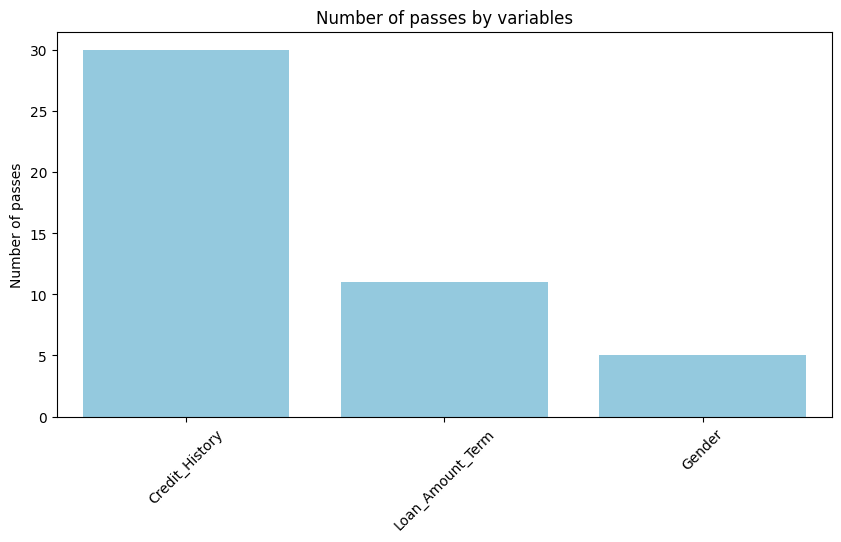

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

missing_data = prediction.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_data.index, y=missing_data.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('Number of passes by variables')
plt.ylabel('Number of passes')
plt.xlabel('')
plt.show()

I fill in the gaps in the integer data with the median, since the distribution of this data is asymmetric and contains outliers. The median is less sensitive to extreme values compared to the average, which makes it a more reliable way to fill in the gaps in such cases.


In [14]:
numerical_omissions = ['Credit_History', 'Loan_Amount_Term']

for n in numerical_omissions:
  prediction[n] = prediction[n].fillna(prediction[n].median())

**To fill in gaps in categorical variables:**

1. I will determine the most common value (mode) for each column.
2. I will convert the categorical data into a numeric format.
3. I will fill in the gaps with the appropriate fashion values for each column.

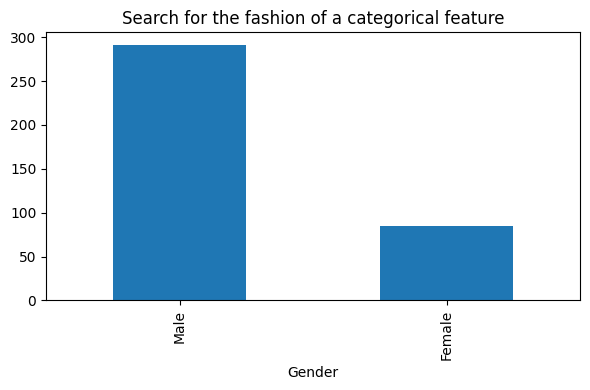

In [15]:
plt.figure(figsize=(6,4))
prediction['Gender'].value_counts().plot(kind='bar')
plt.title('Search for the fashion of a categorical feature')
plt.tight_layout()
plt.show()

Graph analysis shows that the most common value in the Gender attribute is Male. Therefore, the gaps in this column were filled in with the value Male (0).

In [16]:
mapping_dict = {
    'Gender': {'Male': 0, 'Female': 1},
    'Married': {'No': 0, 'Yes': 1},
    'Education': {'Not Graduate': 0, 'Graduate': 1},
    'Loan_Status': {'N': 0, 'Y': 1}
}
prediction['Gender'] = prediction['Gender'].fillna(prediction['Gender'].mode()[0])

for column, mapping in mapping_dict.items():
    prediction[column] = prediction[column].map(mapping).astype(int)

In [17]:
filled = prediction.isnull().sum().sort_values(ascending=False)
print(f'Omissions:\n{filled}')

Omissions:
Gender               0
Married              0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Loan_Status          0
dtype: int64


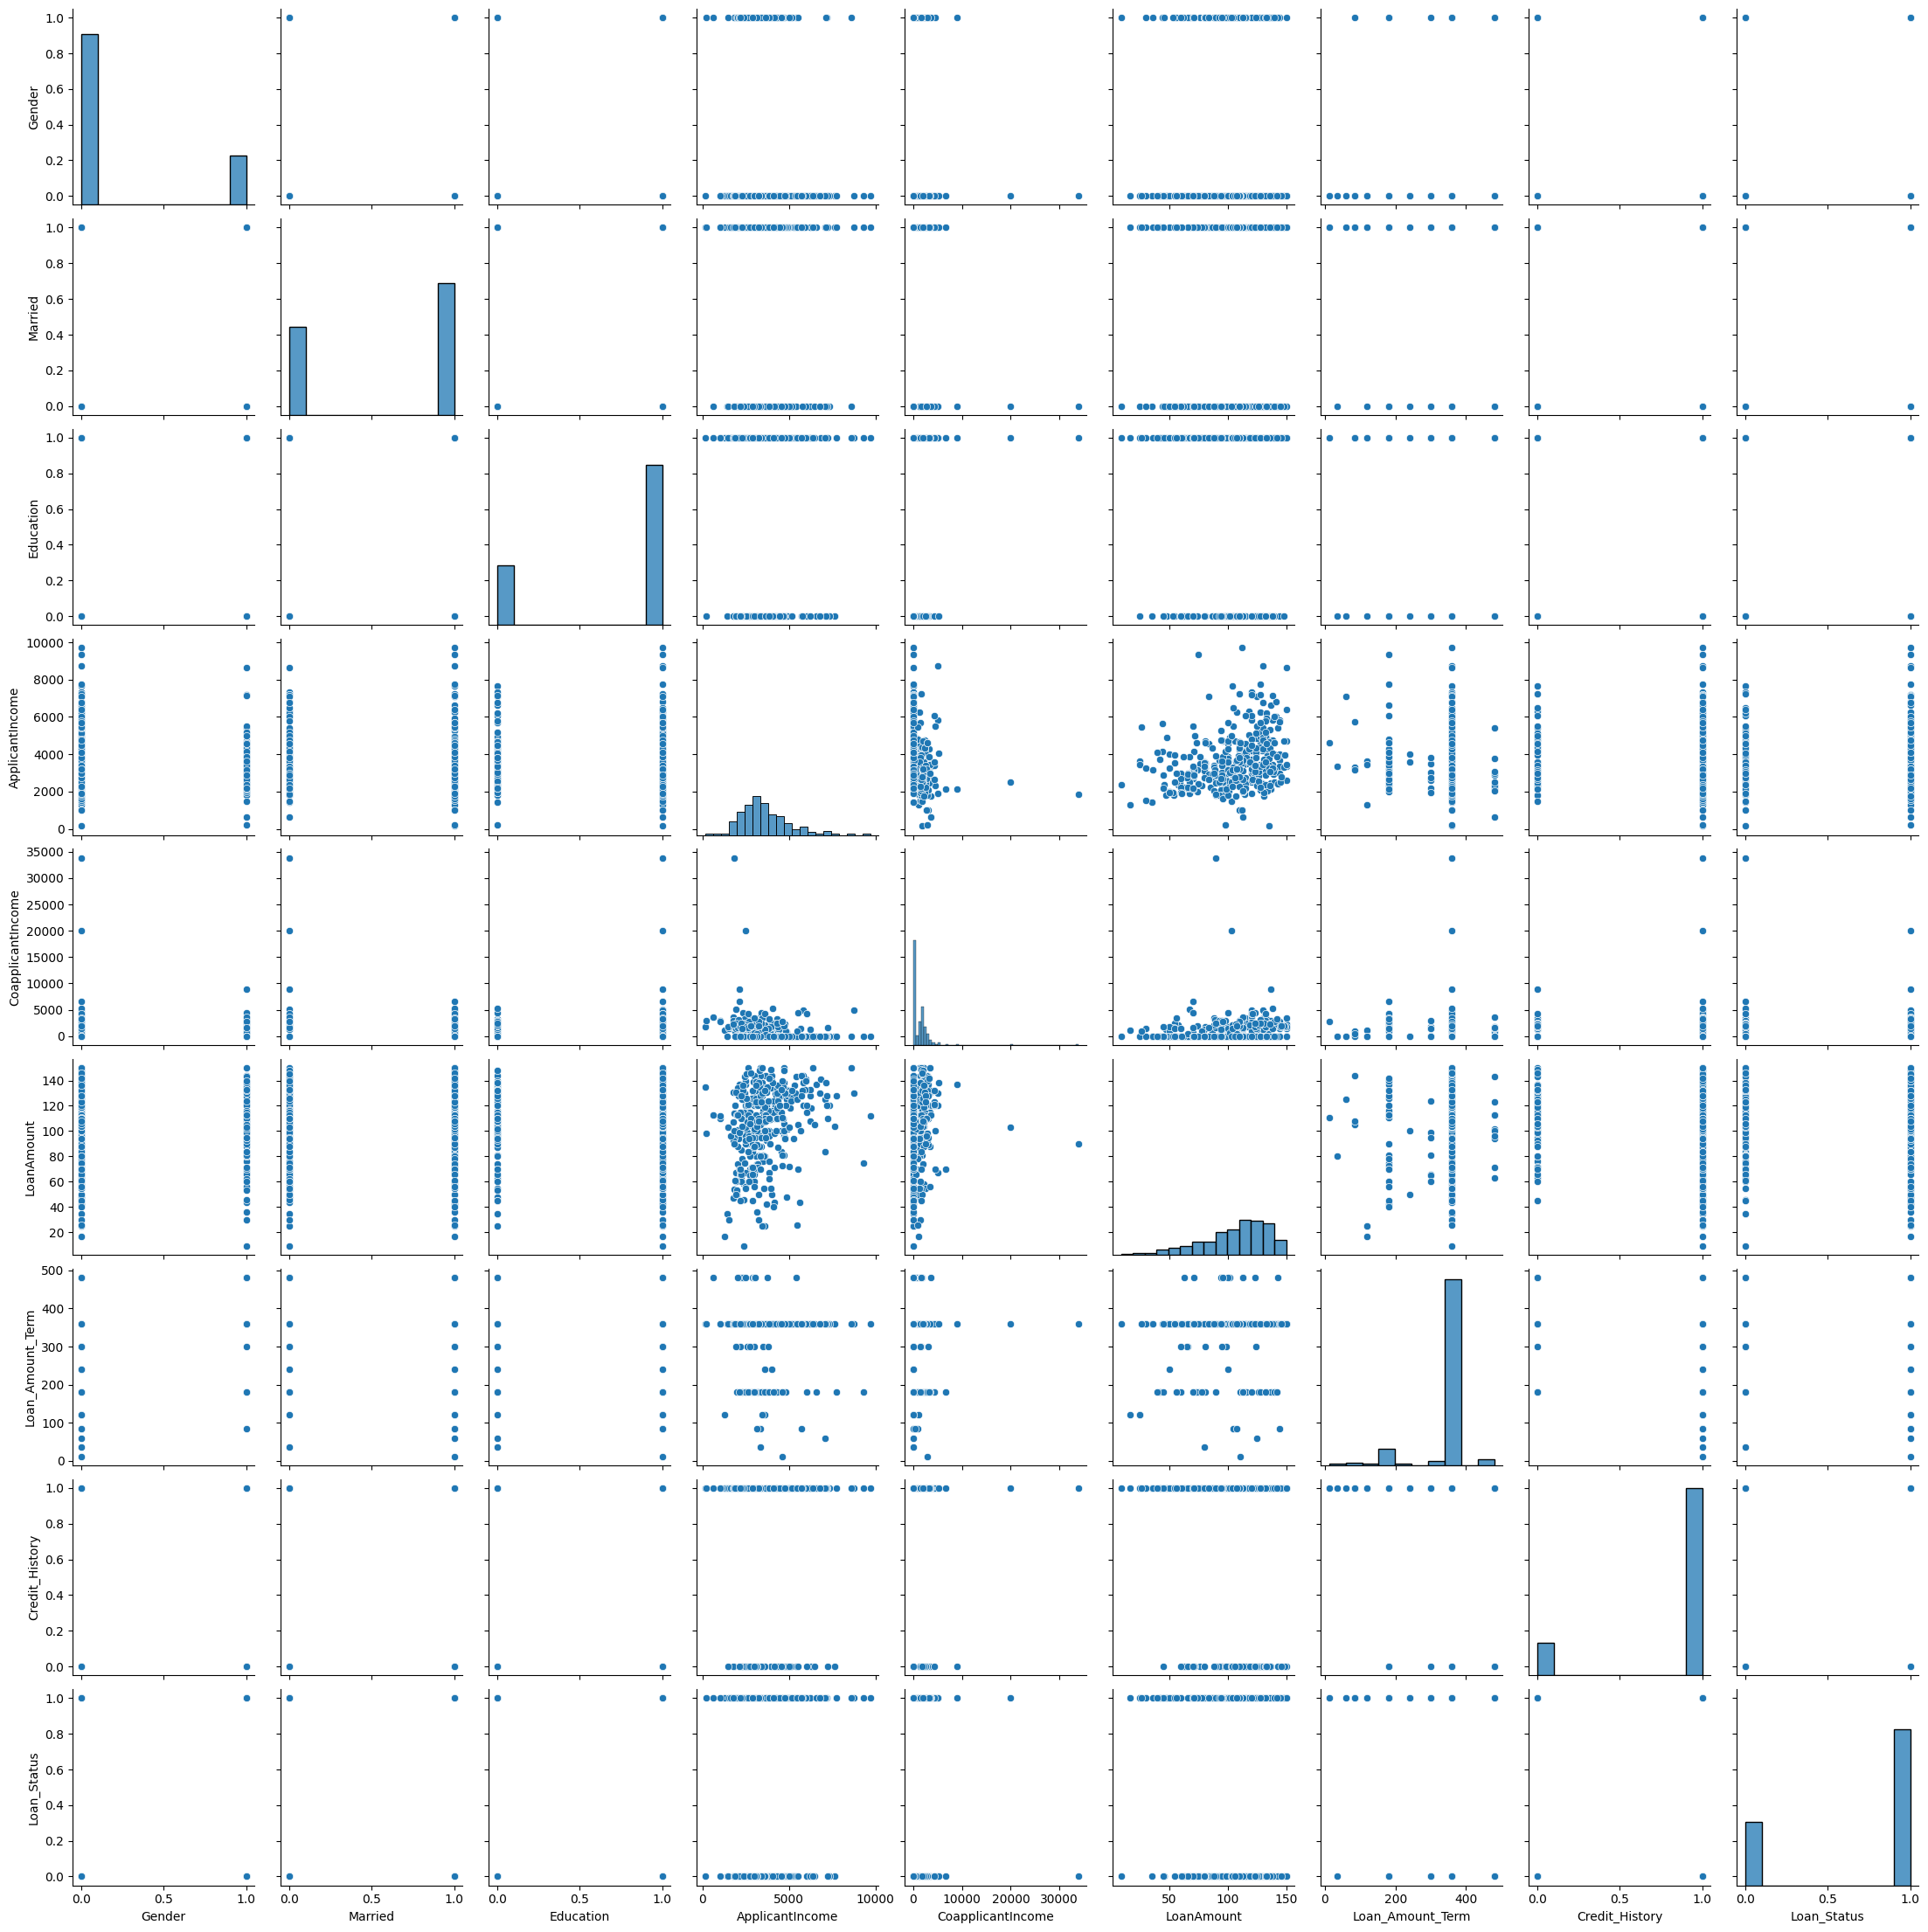

In [18]:
sns.pairplot(prediction)

**The pairplot matrix shows:**

* Gender: The sample is dominated by men. There are no visual correlations between gender and other signs.

* Married: Most of the clients are married. Married borrowers are more likely to have a higher income (ApplicantIncome) and apply for larger loans (loanAmount).

* Education: The vast majority of clients have higher education. They also tend to receive larger loans (loanAmount) and have a higher income (ApplicantIncome).

* ApplicantIncome: The distribution has a right—sided asymmetry - most clients have low incomes. At the same time, high-income clients are more likely to receive large loans and have a good credit history.

* CoapplicantIncome: Many values are zero, which indicates the absence of a co-borrower from a significant part of clients. Co-borrowers are more common among people with high basic income.

* loanAmount: The distribution is asymmetric — most loans are small, but there are some large loans. Customers with high income and a good credit history are more likely to receive large loans.

* Loan_Amount_Term : The distribution is centered around standard values, which indicates typical loan conditions.

* Credit_History: Most customers have a good credit history (1). Having a bad credit history (0) dramatically reduces the likelihood of loan approval.

* Loan_Statuss: The vast majority of applications have been approved (1), which indicates an imbalance of classes.

**Key findings:**

1. Credit_History is the most important feature.

  * It demonstrates a strong relationship with the target variable. Customers with a good credit history have a significantly higher chance of loan approval.

2. Class imbalance in the target variable.

  * The Loan_Status distribution is uneven: the "approved" (1) class prevails, which is important to take into account when training the model.

3. Asymmetry in numerical features.

  * The ApplicantIncome, CoapplicantIncome, and loanAmount attributes have asymmetric distributions. This can negatively affect the logistic regression model, which is sensitive to outliers and scale.

4. The unevenness of categorical features.

  * In categorical variables (Gender, Married, Education), one of the values dominates.

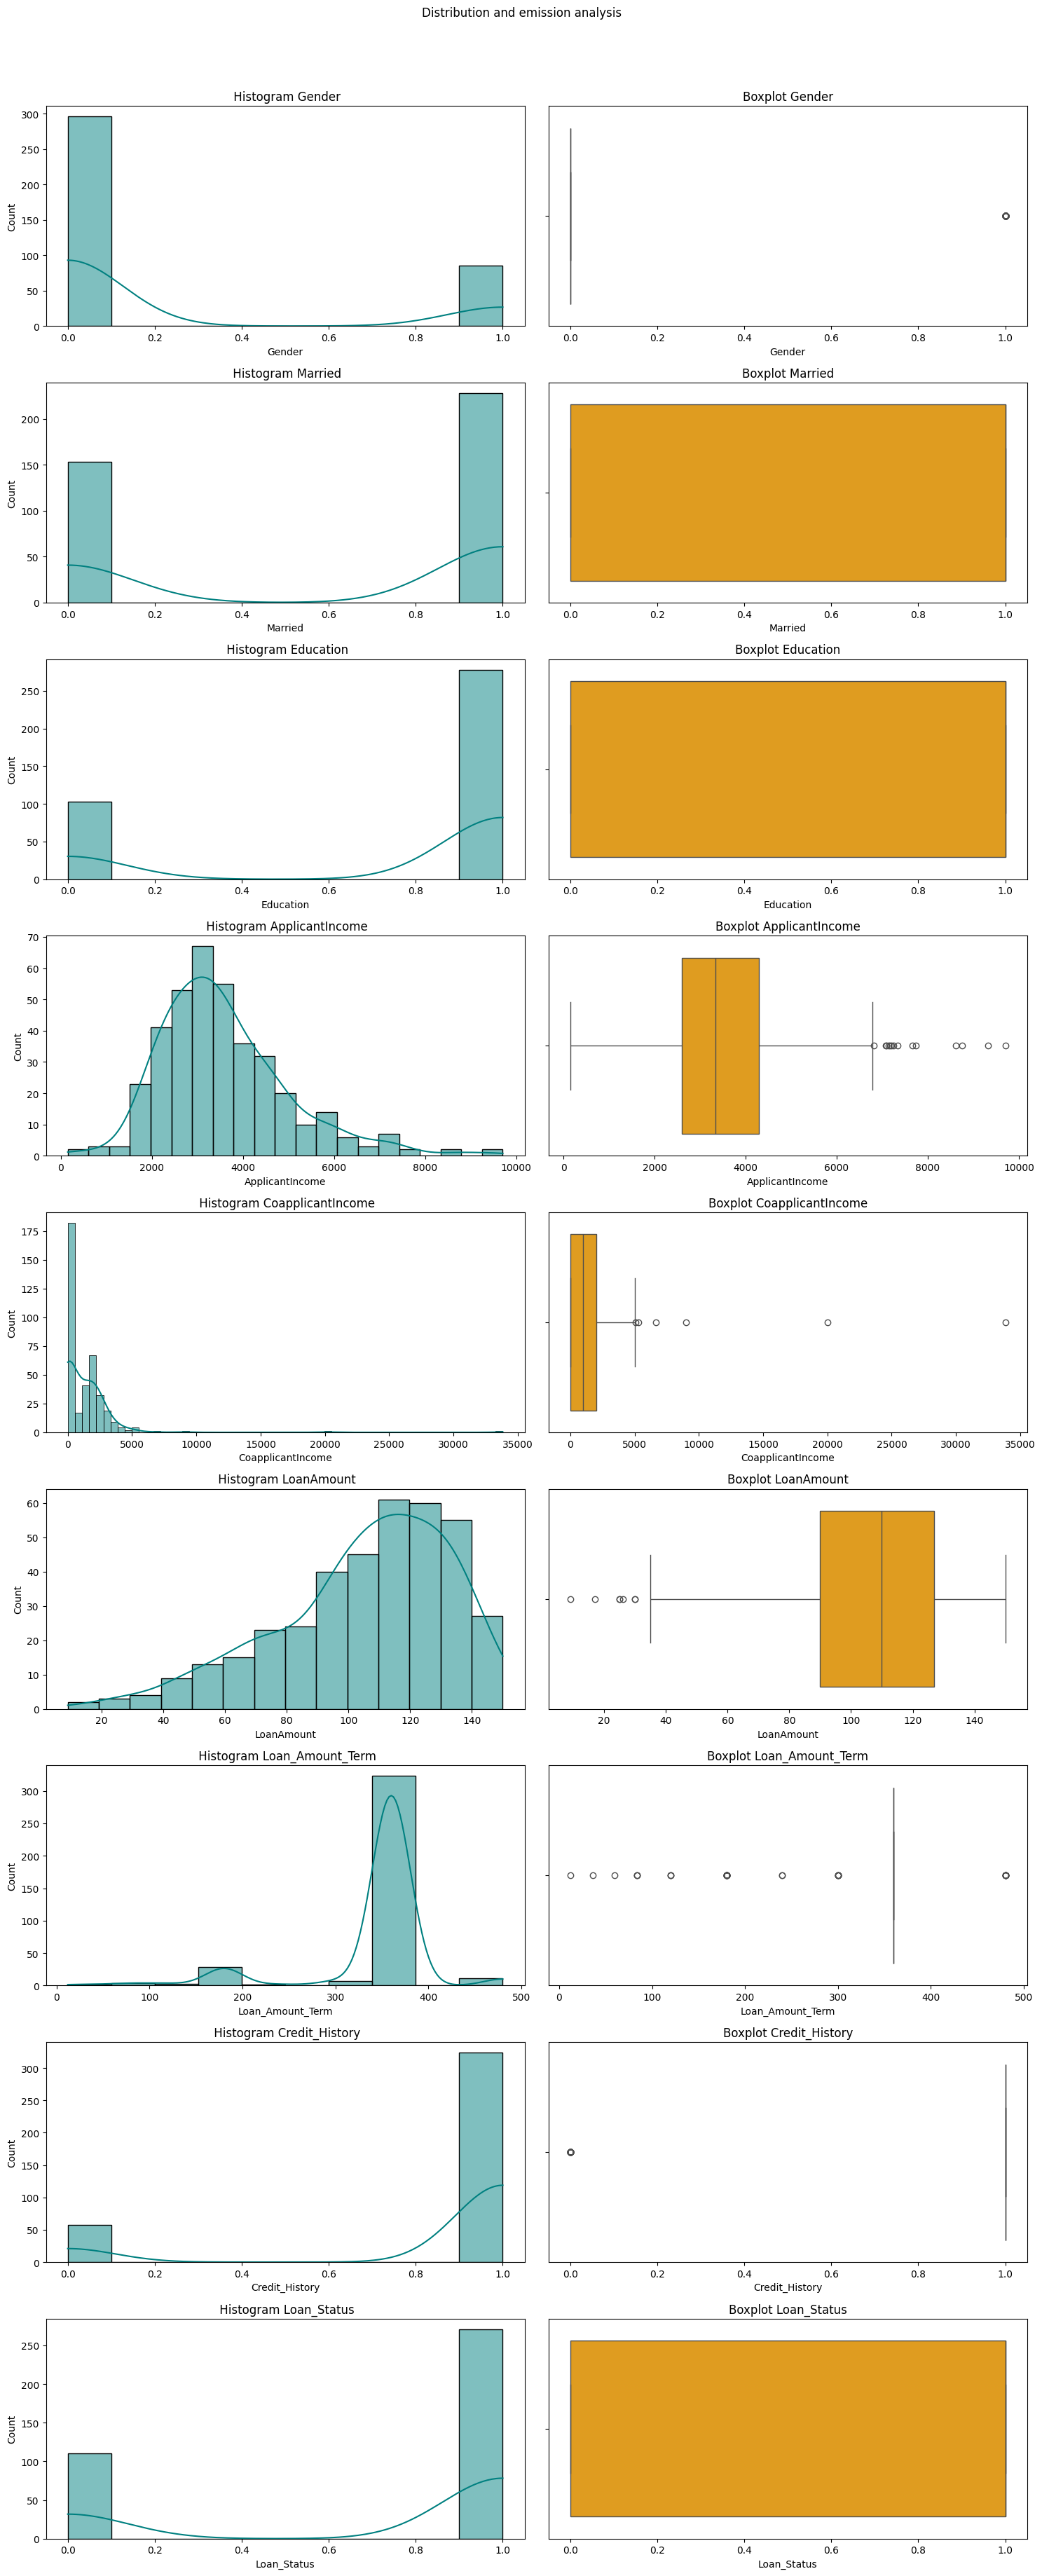

In [19]:
num_cols = prediction.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(nrows=len(num_cols),ncols=2,
                         figsize=(15,4*len(num_cols)))
fig.suptitle('Distribution and emission analysis',y=1.02)

for i, col in enumerate(num_cols):
  sns.histplot(prediction[col], kde=True, ax=axes[i,0],color='teal')
  axes[i,0].set_title(f' Histogram {col}')

  sns.boxplot(x=prediction[col],ax=axes[i,1],color='orange')
  axes[i,1].set_title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

**Key findings from histogram and boxplot analysis:**

1. Asymmetric numerical features (ApplicantIncome, CoapplicantIncome, LoanAmount) require processing to reduce the impact of asymmetry and outliers.
  - I will use RobustScaler without pre-processing emissions, as this scaler is specifically designed for emission tolerance.

2. Categorical features (Gender, Married, Education) are binary, unbalanced, and without outliers.
  - Have been converted to numeric format and do not require further processing.

3. The imbalance of the target variable (Loan_Status) creates difficulties in predicting a low-meeting class, which worsens the quality of the model.
  - To solve this problem, I will use SMOTE, and also use the stratify=y parameter when splitting data. Thanks to it, when dividing the data into training and test data, the same class ratio is maintained.

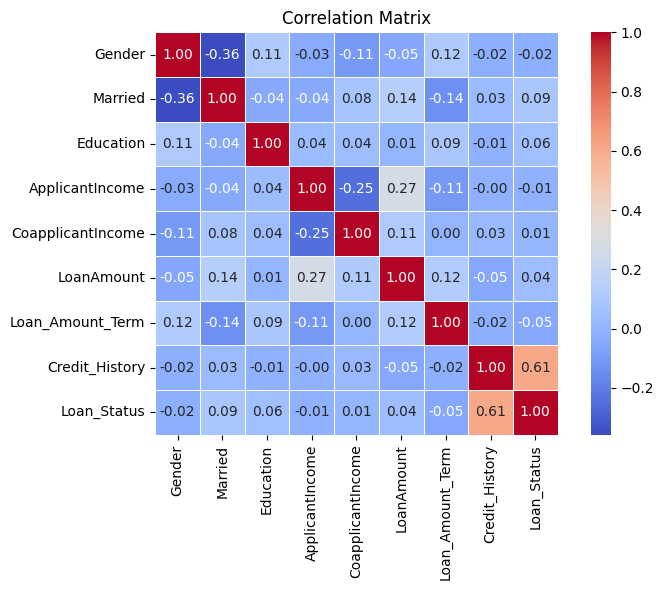

In [20]:
correlation_matrix = prediction.corr()
plt.figure(figsize=(8,6))

sns.heatmap(correlation_matrix, annot=True,fmt='.2f',cmap='coolwarm',
            square=True,linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

**Based on the correlation matrix, the following conclusions can be drawn:**

* Credit_History is the most important feature, as it has a strong positive correlation with Loan_Status (+0.61).

* Correlations of ApplicantIncome and CoapplicantIncome (-0.25) indicate the relationship between the basic income and the income of the co-borrower. High-income clients can cover the loan on their own, while those with low incomes attract a co-borrower.

* Correlation between Married and Gender(-0.36) the more men there are, the more likely they are to be married.

* The correlation between ApplicantIncome and LoanAmount(+0.27) indicates that financially stable borrowers receive large loans.

* Most features have a weak correlation with the target variable (Loan_Status), which indicates their limited role in modeling. However, they should be left in the model, as even weak features can contribute to the overall quality, especially when combined with other factors.

* There are no high correlations between numerical features (all below 0.7), which reduces their contribution to the predictive model.



**The result of data analysis:**

* Removed uninformative features and redundant categorical columns

* Checking for duplicate rows did not reveal duplicate entries

* The gaps are filled in:

    * For the numerical attributes Credit_History, Loan_Amount_Term, the missing values were filled in with the median, as it is resistant to outliers and skewness.

    * For categorical Gender signs, the gaps are filled in by fashion, which is the most common value.

* All categorical features have been converted to numerical form. Gender, Married, Education, Loan_Status were encoded in numeric format (0/1).

* There are ApplicantIncome, CoapplicantIncome, and LoanAmount outliers in the data, but it was decided not to delete them, but to use RobustScaler for scaling. This method is resistant to outliers, as it is based on the median and interquartile range (IQR), which makes the model more stable.

* All the remaining features are preserved in the model, since each of them has a theoretical justification and practical significance.:

    * Customer data Married, Gender, Education, ApplicantIncome stores information about social status and income level.

    * The credit characteristics of LoanAmount, Credit_History, CoapplicantIncome, Loan_Amount_Term reflect the loan terms and creditworthiness.

 Logistic regression is able to take into account the contribution of each feature, even if its individual impact is small.

## 3. Development of a logical regression model for predicting loan approval

Methodology of training and model settings:

1. Dividing the dataset into features (x) and a target variable (y).

2. Random splitting of data into training and test samples in an 80/20 ratio with a fixed random_state for reproducibility of results and the stratify=y parameter, which preserves the same class ratio.

3. Scaling of the ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term attributes.

RobustScaler was used to eliminate differences in scale and emissions management. This is necessary because the features have different ranges of values and significant outliers, which can lead to an incorrect assessment of their importance by the logical regression model.

Advantages of RobustScaler:

* Resistant to emissions (based on median and IQR)

* Preserves the distribution structure

* Brings the signs to a comparable scale

* Allows you to correctly interpret the coefficients of the model.

4. Saving the scale of the Loan_Status target variable.

5. Combating class imbalance.

Since the Loan_Status target variable is unbalanced (most loans are approved), SMOTE was applied - a synthetic increase in the rare class (only on the training sample).This allows the model to learn better from examples with a negative outcome and avoid bias.

6. Training the logistic regression model

7. Generation of forecasts for training and test samples.

8. Quality assessment using a set of metrics (Accuracy, Precision, Recall, F1-score) for an objective assessment of model performance.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE

x = prediction.drop('Loan_Status', axis=1)
y = prediction['Loan_Status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

scaler = RobustScaler()
features_to_robust = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

x_train_scaled[features_to_robust] = scaler.fit_transform(x_train[features_to_robust])
x_test_scaled[features_to_robust] = scaler.transform(x_test[features_to_robust])

smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_scaled, y_train)

logreg = LogisticRegression()
logreg.fit(x_train_balanced, y_train_balanced)

y_pred_train = logreg.predict(x_train_balanced)
y_pred_test = logreg.predict(x_test_scaled)


metrics = {
    'Training sample (after SMOTE)': {
'Accuracy': accuracy_score(y_train_balanced, y_pred_train),
        'Precision': precision_score(y_train_balanced, y_pred_train),
        'Recall': recall_score(y_train_balanced, y_pred_train),
        'F1-score': f1_score(y_train_balanced, y_pred_train)
    },
    'Test sample': {
'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1-score': f1_score(y_test, y_pred_test)
    }
}

for dataset, values in metrics.items():
    print(f"\n{dataset}:")
    print(f"- Accuracy: {values['Accuracy']:.4f}")
    print(f"- Precision: {values['Precision']:.4f}")
    print(f"- Recall: {values['Recall']:.4f}")
    print(f"- F1-score: {values['F1-score']:.4f}")


Training sample (after SMOTE):
- Accuracy: 0.8079
- Precision: 0.7350
- Recall: 0.9630
- F1-score: 0.8337

Test sample:
- Accuracy: 0.8701
- Precision: 0.8462
- Recall: 1.0000
- F1-score: 0.9167


## 4. Evaluation and interpretation of model quality metrics

The following metrics were selected for an objective assessment of the quality of the logical regression model:

1. Recall (Sensitivity, Completeness) — important to minimize missed good clients.

  * In the case of loans, skipping potentially solvent borrowers is a lost profit. A high Recall means that the model is good at catching those who actually pay, and does not reject them for no reason.

2. Precision is important to limit the risk of bad borrowers.

    * High Precision means that most approved loans are actually refunded. This is important to reduce losses from non-refunds.
  
3. F1-score — the balance between Precision and Recall.

  * In real practice, it is important to find a compromise between avoiding paying customers and at the same time preventing loans from unreliable borrowers.

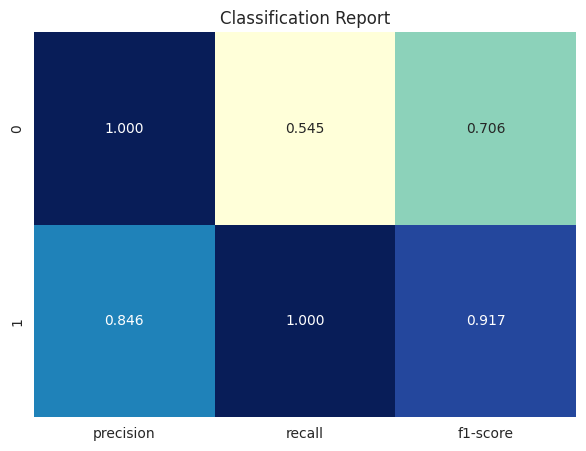

In [47]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_test, output_dict=True)
df_report = pd.DataFrame(report).iloc[:-1, :2].T

plt.figure(figsize=(7, 5))
sns.heatmap(df_report, annot=True, cmap="YlGnBu", fmt=".3f", cbar=False)
plt.title("Classification Report")
plt.show()

The graph shows the results for two classes: 0 (loan denial) and 1 (loan approval). Here are the main findings:

* Class 1 (loan approval):

    - The model perfectly copes with not missing a single case of loan approval (Recall = 1.000), but it allows for a certain proportion of false positive errors (Precision = 0.846). This means that the model sometimes mistakenly approves loans that should be rejected.

    - A high F1 score (0.917) for Class 1 indicates that the model is effective in detecting approved loans.
     

 * Class 0 (loan denial):

    - The model does a very good job of not making mistakes when rejecting loans (Precision = 1.000), but it skips about half of the actual rejections (Recall = 0.545). This can be critical if it is important to minimize the risks of incorrect loan approval.

    - F1-score = 0.706 is relatively low, indicating that the model is worse at recognizing negative cases than positive ones.

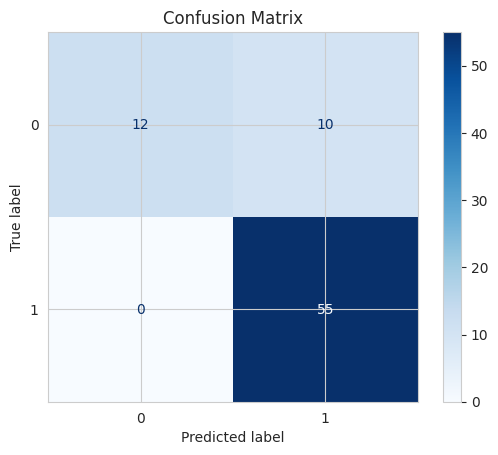

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()

The Error Matrix shows how the model classified the examples into two classes (0 and 1).

* Class 1 (Loan Approval):

   - Correctly classified: 55 of the loans that were actually approved.

   - False negative errors: 0 credits, the model handled this aspect perfectly.

* Class 0 (Loan Denial):   

  - False positive errors : 10 credits that should have been rejected, the model mistakenly approved.
  - Correctly classified: 12 credits, which indicates insufficient accuracy in recognizing class 0.